In [33]:
# made by Gibeom LEE, HI LAB
# 한 폴더 내 모든 csv 파일의 TENG Vpp값을 구할 때 유용합니다.
# +250806 각 frequency도 같이 보여줍니다.

In [34]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [35]:
# 폴더 경로
folder_path = r"C:\Users\GCU\OneDrive - gachon.ac.kr\HI Lab\0. Projects\0. On going\2. Aloe inspired DEG\0. 실험자료\4. Data measurement\250810_표만들기_128개의 눈물\minimized_csv파일_4060"

# 사용자 설정값
prominence_ratio = 0.3 # 신호의 표준편차(std)에 곱해 피크 prominence 기준을 설정 / 주변 값보다 얼마나 돌출된 정도여야 피크로 인식할지를 결정
min_prominence = 0.1 # prominence의 최솟값 제한 / std가 너무 작아서 prominence가 너무 낮게 계산되는 경우를 방지
min_distance_sec = 0.25 #인접한 피크 간 최소 시간 간격 (초 단위)
snr_threshold = 1 # Signal-to-Noise Ratio 기준값 / 값이 높을수록 강한 피크만 통과
min_relative_height = 0.05 # 전체 최대 진폭의 5% 이상 

Aloe_30_40_2_Vpp: 5.09 V
Aloe_30_40_2_Peak number: 21개
Aloe_30_40_2_표준편차: 0.79
Aloe_30_40_2_주파수: 2.48 Hz


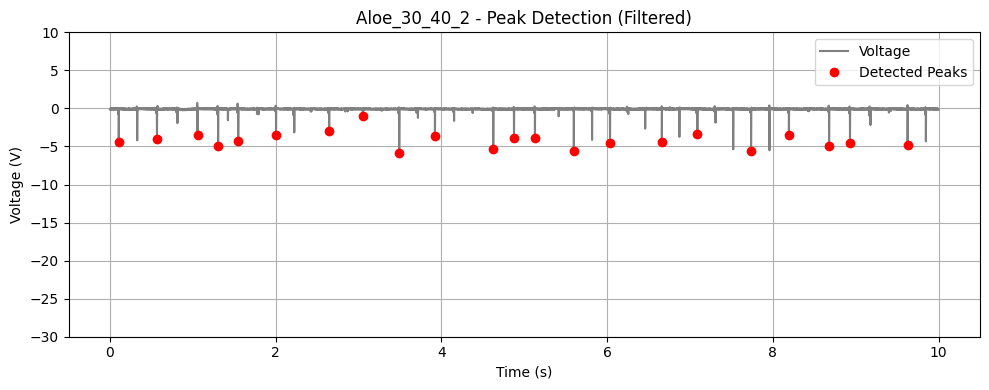

Aloe_30_40_4_Vpp: 6.26 V
Aloe_30_40_4_Peak number: 20개
Aloe_30_40_4_표준편차: 3.75
Aloe_30_40_4_주파수: 2.44 Hz


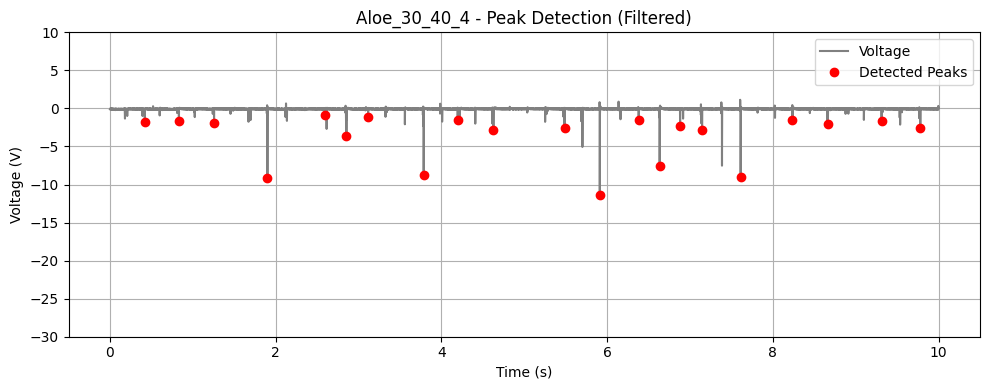

Aloe_30_40_6_Vpp: 7.91 V
Aloe_30_40_6_Peak number: 20개
Aloe_30_40_6_표준편차: 2.78
Aloe_30_40_6_주파수: 2.39 Hz


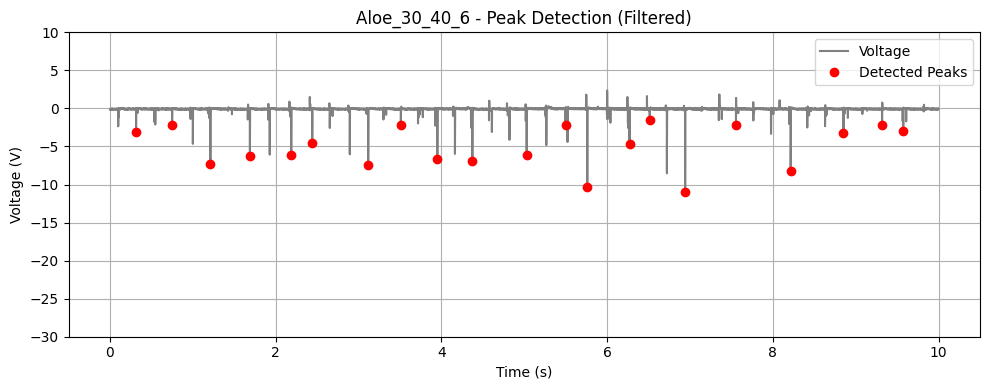

Aloe_30_40_8_Vpp: 9.41 V
Aloe_30_40_8_Peak number: 20개
Aloe_30_40_8_표준편차: 4.85
Aloe_30_40_8_주파수: 2.32 Hz


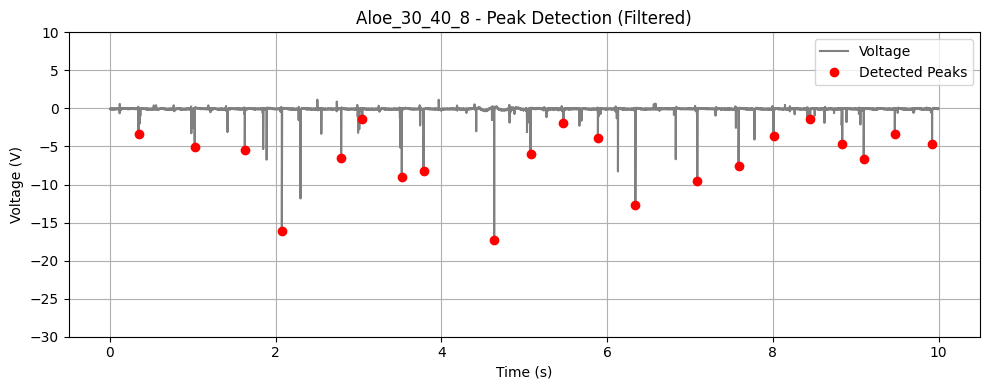

Aloe_30_60_2_Vpp: 5.89 V
Aloe_30_60_2_Peak number: 19개
Aloe_30_60_2_표준편차: 1.20
Aloe_30_60_2_주파수: 2.09 Hz


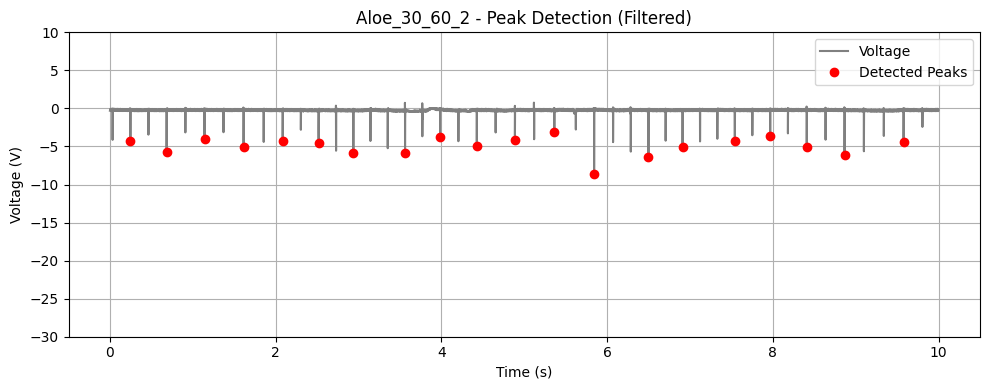

Aloe_30_60_4_Vpp: 7.39 V
Aloe_30_60_4_Peak number: 20개
Aloe_30_60_4_표준편차: 1.52
Aloe_30_60_4_주파수: 2.16 Hz


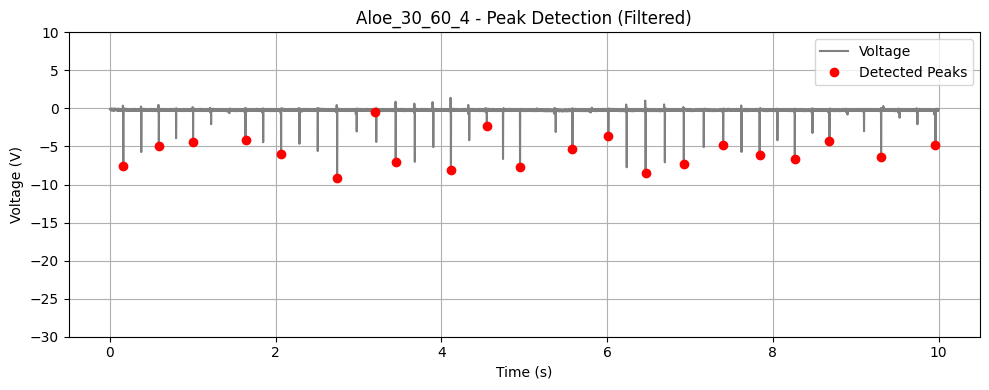

Aloe_30_60_6_Vpp: 10.39 V
Aloe_30_60_6_Peak number: 20개
Aloe_30_60_6_표준편차: 3.15
Aloe_30_60_6_주파수: 2.18 Hz


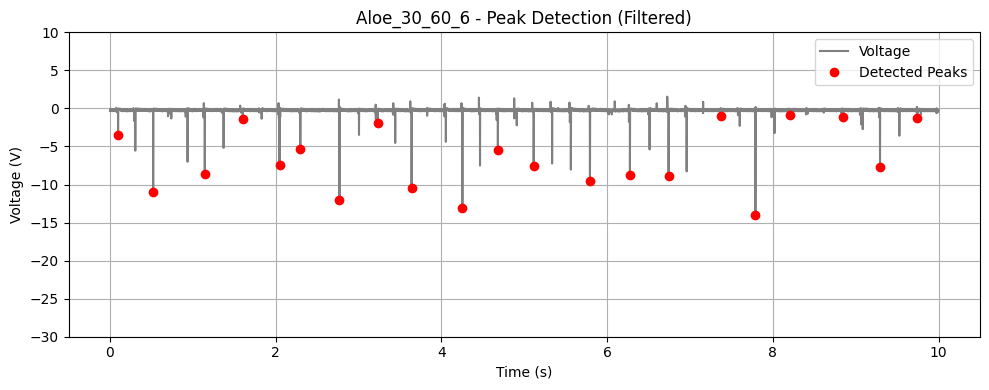

Aloe_30_60_8_Vpp: 6.29 V
Aloe_30_60_8_Peak number: 20개
Aloe_30_60_8_표준편차: 4.36
Aloe_30_60_8_주파수: 2.19 Hz


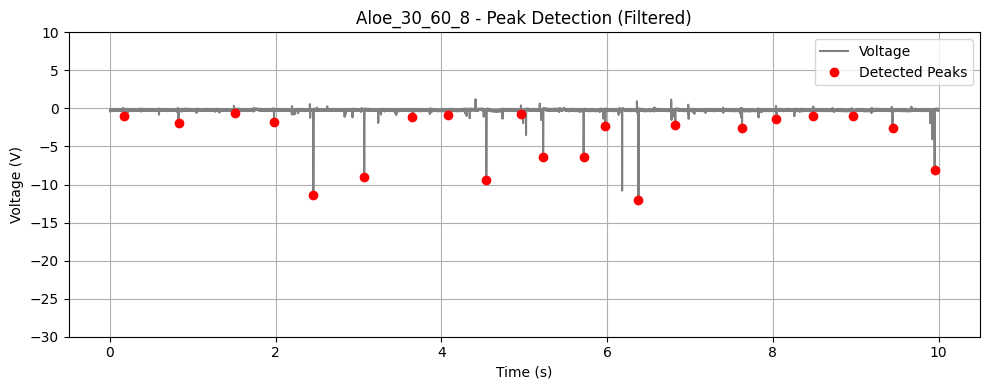

Aloe_45_40_2_Vpp: 7.02 V
Aloe_45_40_2_Peak number: 20개
Aloe_45_40_2_표준편차: 1.13
Aloe_45_40_2_주파수: 2.24 Hz


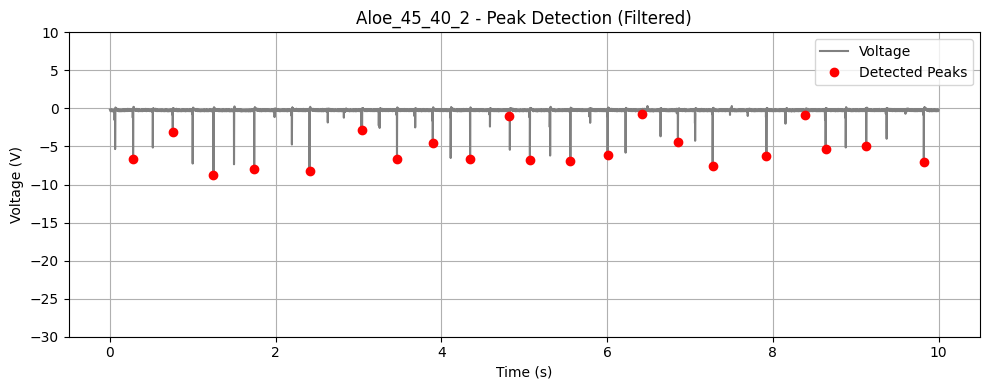

Aloe_45_40_4_Vpp: 11.47 V
Aloe_45_40_4_Peak number: 21개
Aloe_45_40_4_표준편차: 3.02
Aloe_45_40_4_주파수: 2.22 Hz


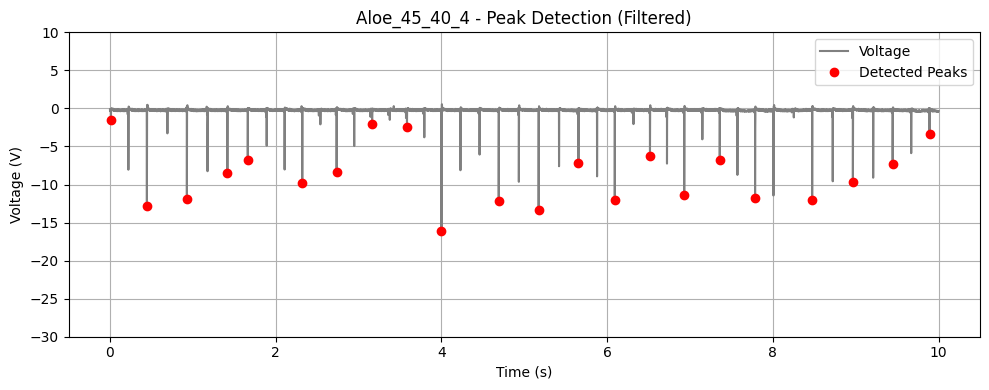

Aloe_45_40_6_Vpp: 13.36 V
Aloe_45_40_6_Peak number: 19개
Aloe_45_40_6_표준편차: 3.02
Aloe_45_40_6_주파수: 2.10 Hz


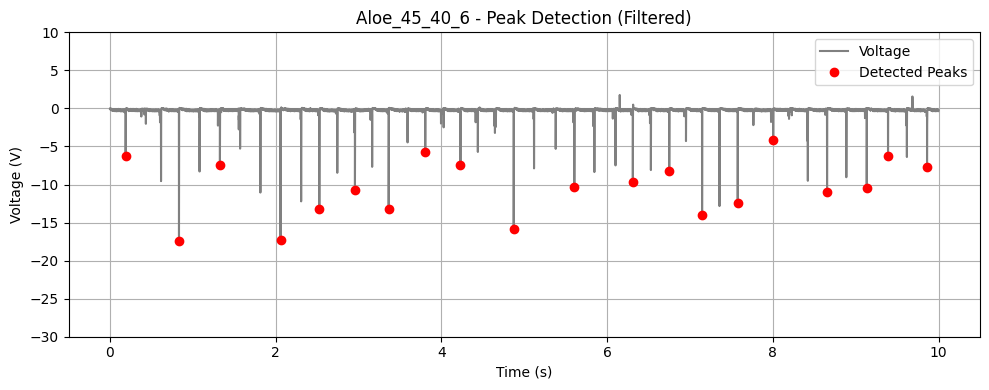

Aloe_45_40_8_Vpp: 15.33 V
Aloe_45_40_8_Peak number: 21개
Aloe_45_40_8_표준편차: 5.86
Aloe_45_40_8_주파수: 2.47 Hz


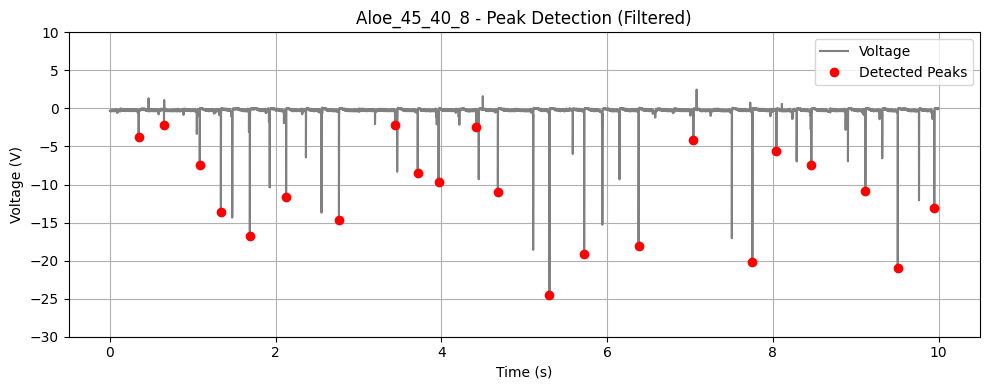

Aloe_45_60_2_Vpp: 6.99 V
Aloe_45_60_2_Peak number: 20개
Aloe_45_60_2_표준편차: 0.62
Aloe_45_60_2_주파수: 2.14 Hz


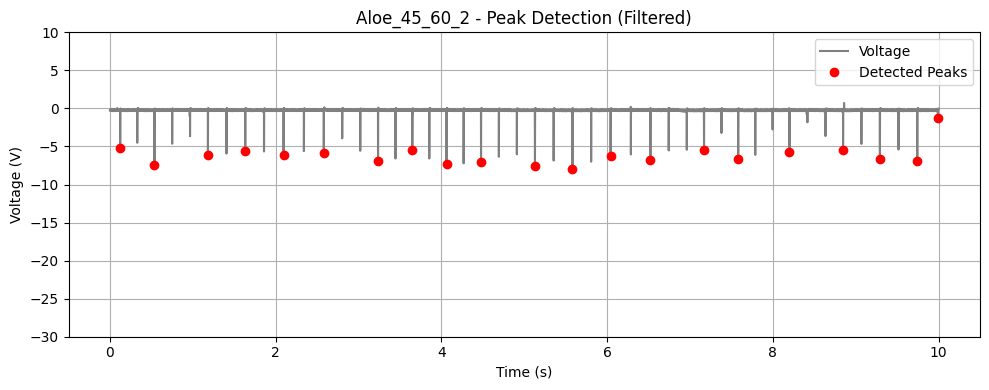

Aloe_45_60_4_Vpp: 11.93 V
Aloe_45_60_4_Peak number: 20개
Aloe_45_60_4_표준편차: 1.58
Aloe_45_60_4_주파수: 2.18 Hz


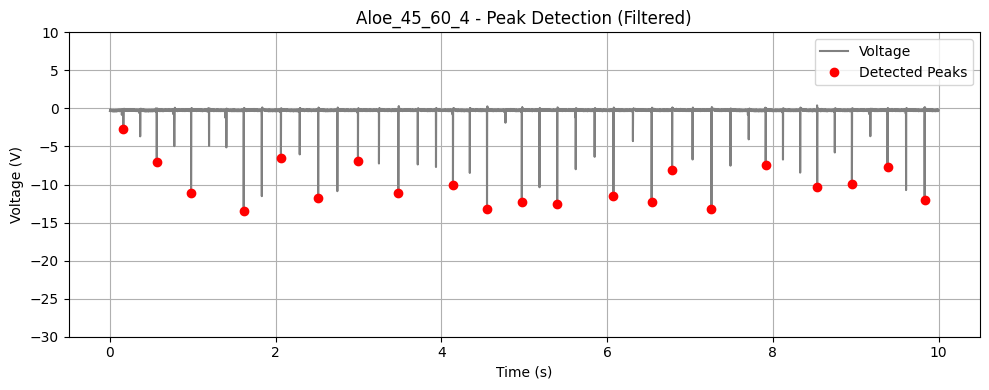

Aloe_45_60_6_Vpp: 10.63 V
Aloe_45_60_6_Peak number: 18개
Aloe_45_60_6_표준편차: 1.96
Aloe_45_60_6_주파수: 2.00 Hz


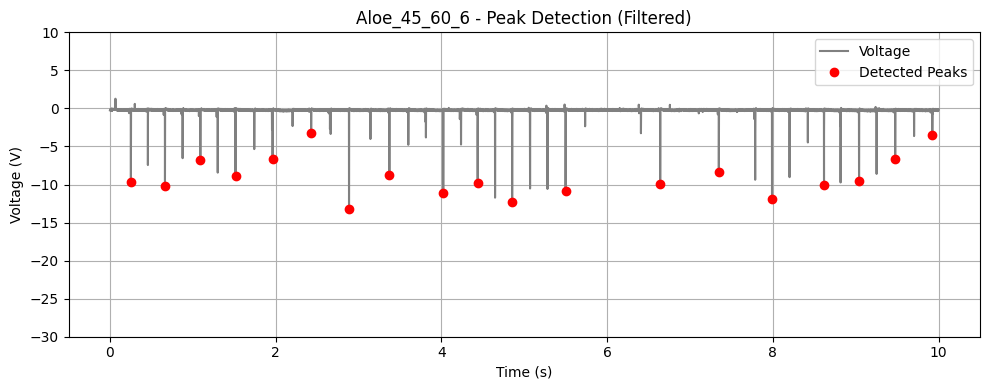

Aloe_45_60_8_Vpp: 11.51 V
Aloe_45_60_8_Peak number: 20개
Aloe_45_60_8_표준편차: 3.68
Aloe_45_60_8_주파수: 2.20 Hz


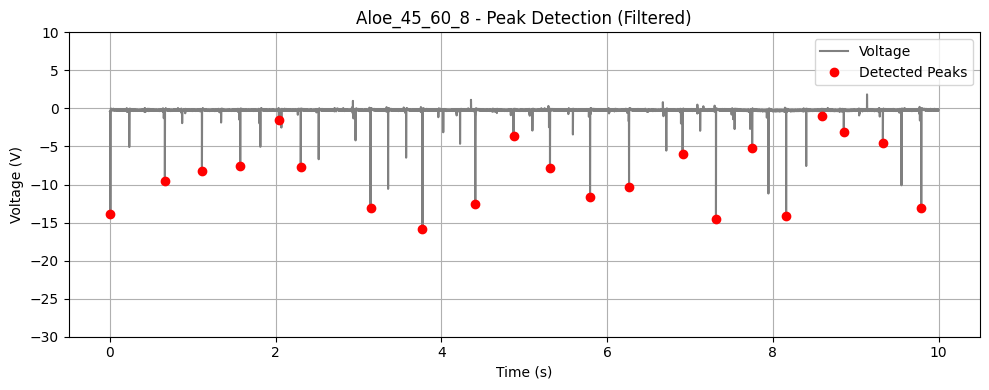

Aloe_60_40_2_Vpp: 7.19 V
Aloe_60_40_2_Peak number: 23개
Aloe_60_40_2_표준편차: 0.91
Aloe_60_40_2_주파수: 2.71 Hz


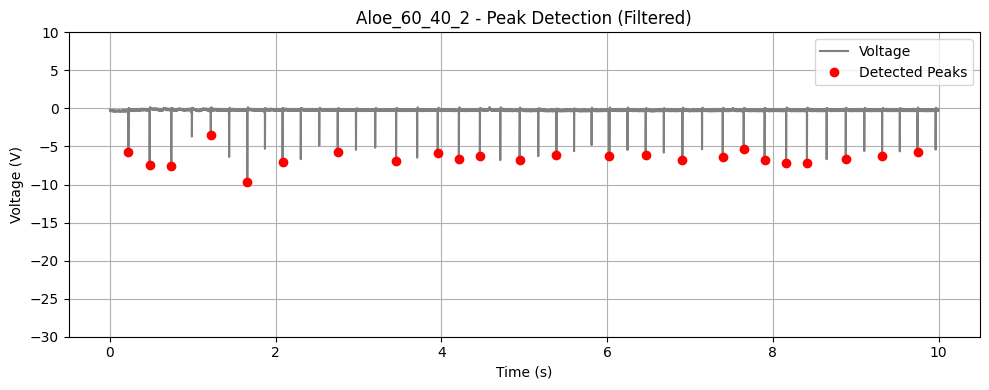

Aloe_60_40_4_Vpp: 10.45 V
Aloe_60_40_4_Peak number: 21개
Aloe_60_40_4_표준편차: 1.63
Aloe_60_40_4_주파수: 2.32 Hz


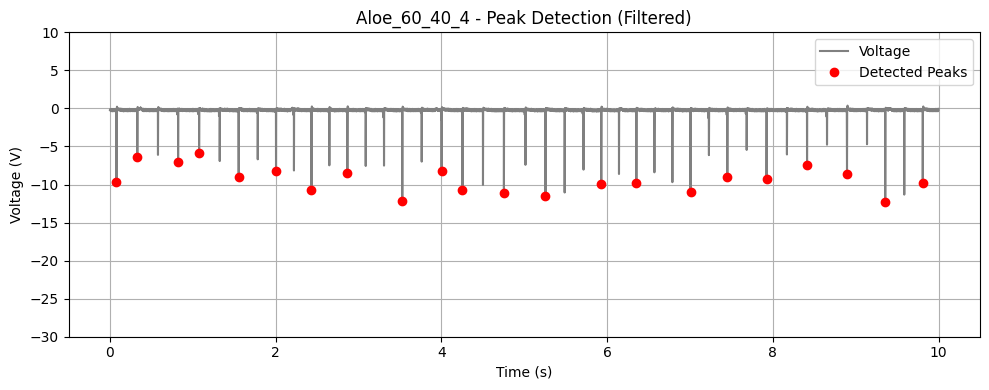

Aloe_60_40_6_Vpp: 12.53 V
Aloe_60_40_6_Peak number: 22개
Aloe_60_40_6_표준편차: 1.03
Aloe_60_40_6_주파수: 2.53 Hz


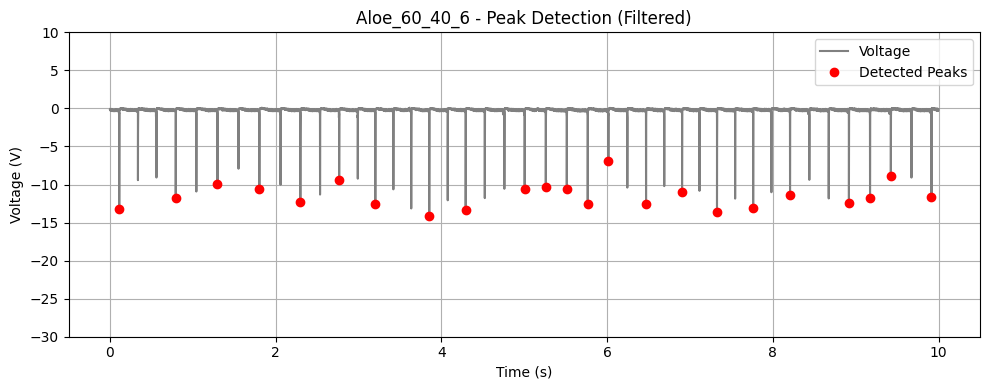

Aloe_60_40_8_Vpp: 19.79 V
Aloe_60_40_8_Peak number: 19개
Aloe_60_40_8_표준편차: 2.96
Aloe_60_40_8_주파수: 2.23 Hz


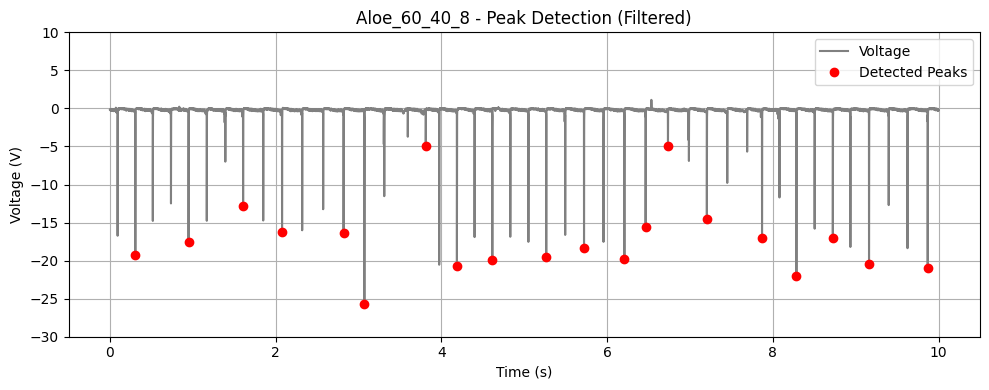

Aloe_60_60_2_Vpp: 4.75 V
Aloe_60_60_2_Peak number: 26개
Aloe_60_60_2_표준편차: 0.36
Aloe_60_60_2_주파수: 2.96 Hz


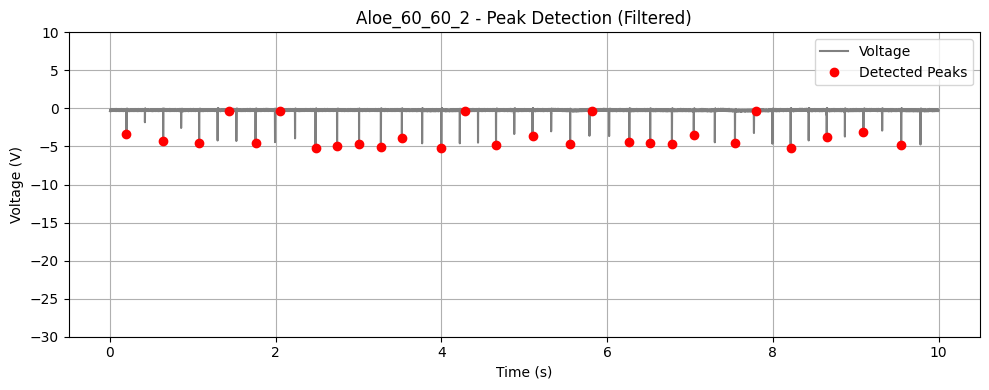

Aloe_60_60_4_Vpp: 8.41 V
Aloe_60_60_4_Peak number: 24개
Aloe_60_60_4_표준편차: 0.59
Aloe_60_60_4_주파수: 2.84 Hz


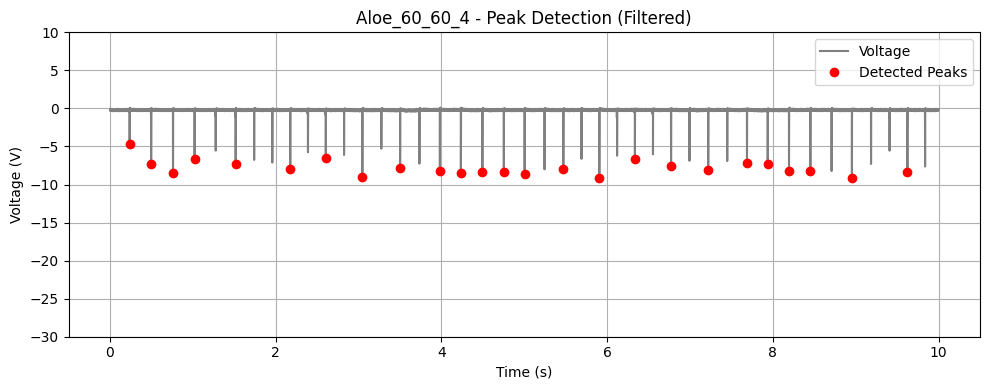

Aloe_60_60_6_Vpp: 11.77 V
Aloe_60_60_6_Peak number: 21개
Aloe_60_60_6_표준편차: 2.01
Aloe_60_60_6_주파수: 2.30 Hz


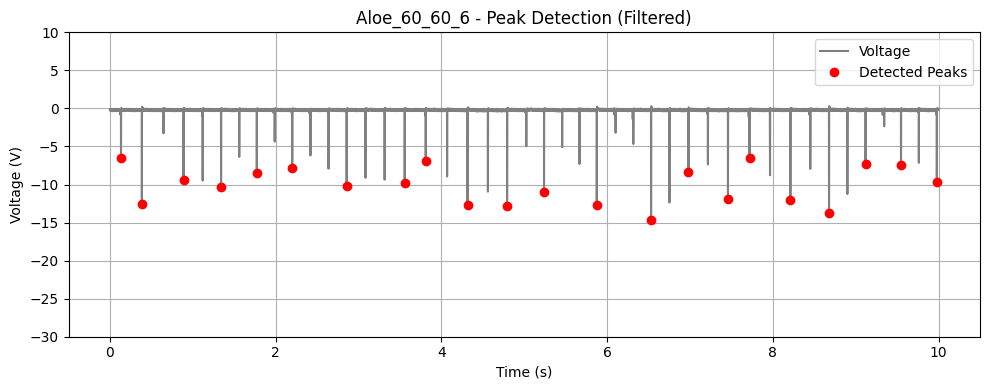

Aloe_60_60_8_Vpp: 14.47 V
Aloe_60_60_8_Peak number: 19개
Aloe_60_60_8_표준편차: 1.75
Aloe_60_60_8_주파수: 2.16 Hz


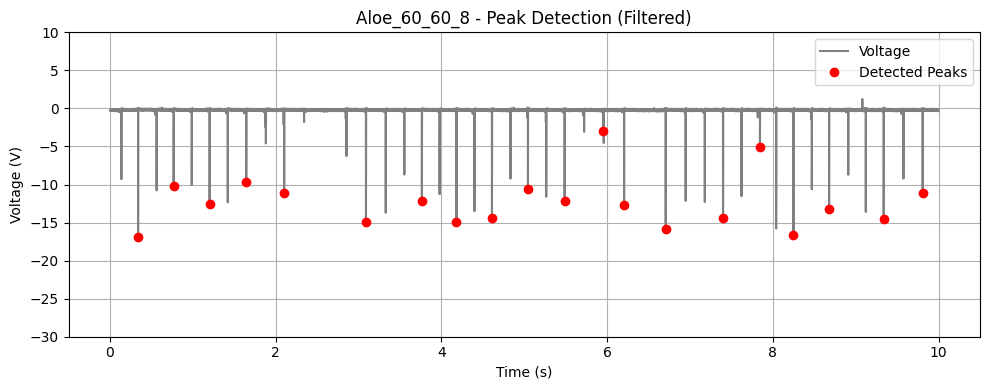

Aloe_75_40_2_Vpp: 4.58 V
Aloe_75_40_2_Peak number: 27개
Aloe_75_40_2_표준편차: 1.32
Aloe_75_40_2_주파수: 2.99 Hz


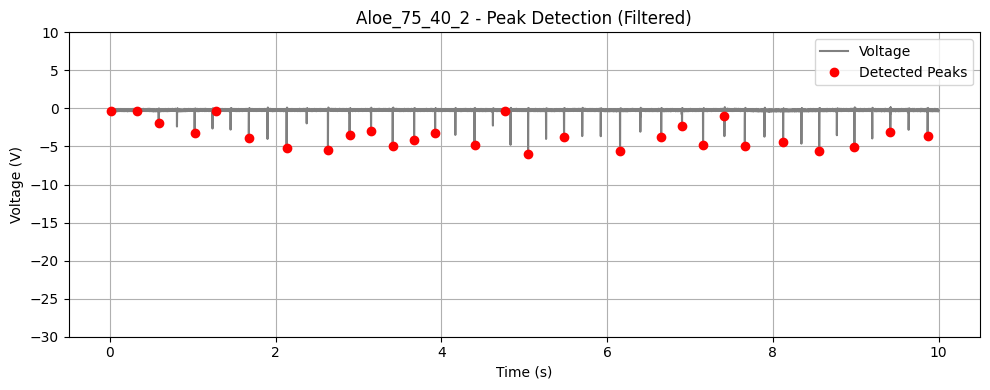

Aloe_75_40_4_Vpp: 5.83 V
Aloe_75_40_4_Peak number: 24개
Aloe_75_40_4_표준편차: 0.70
Aloe_75_40_4_주파수: 2.58 Hz


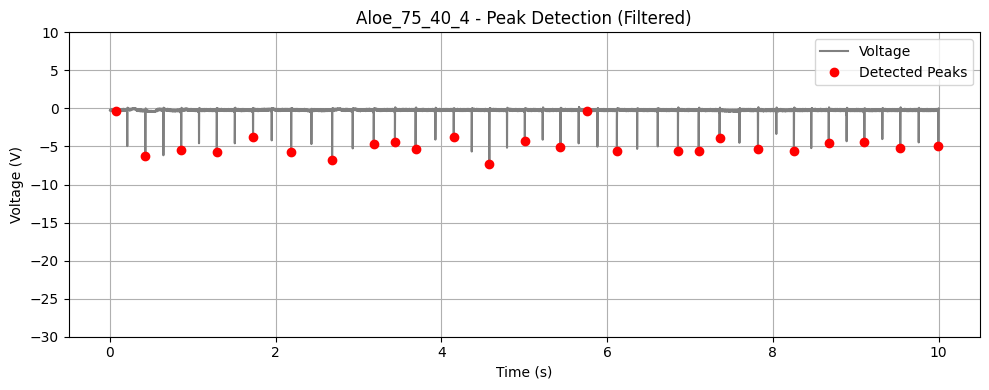

Aloe_75_40_6_Vpp: 8.38 V
Aloe_75_40_6_Peak number: 20개
Aloe_75_40_6_표준편차: 0.98
Aloe_75_40_6_주파수: 2.33 Hz


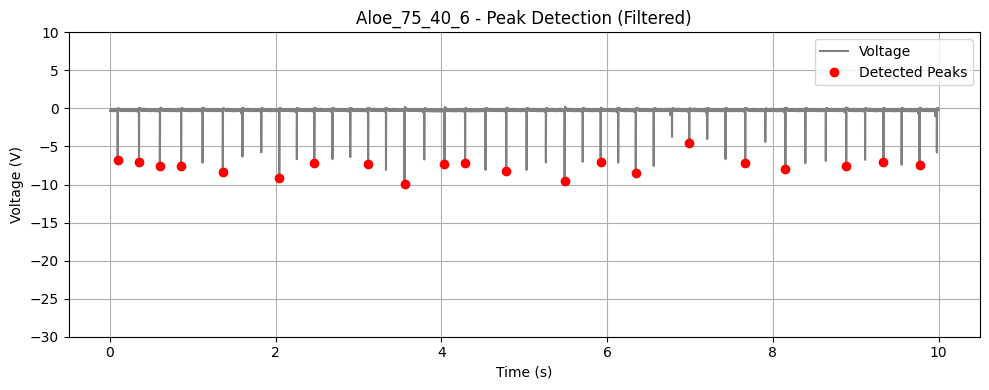

Aloe_75_40_8_Vpp: 13.44 V
Aloe_75_40_8_Peak number: 22개
Aloe_75_40_8_표준편차: 1.43
Aloe_75_40_8_주파수: 2.51 Hz


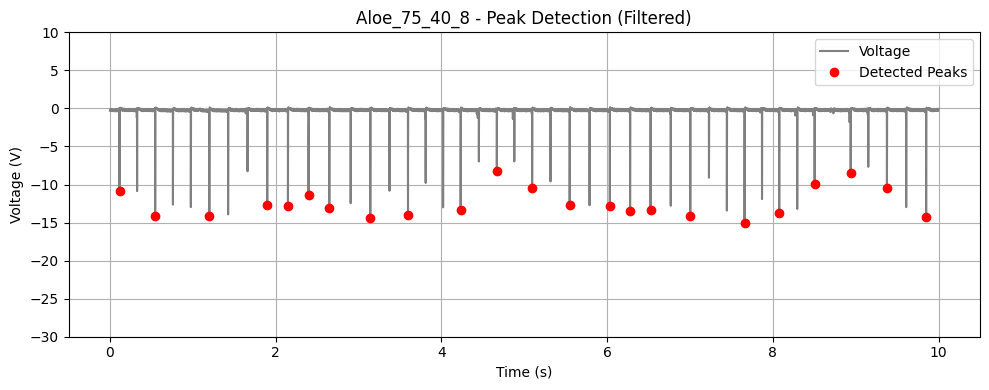

Aloe_75_60_2_Vpp: 5.59 V
Aloe_75_60_2_Peak number: 25개
Aloe_75_60_2_표준편차: 1.01
Aloe_75_60_2_주파수: 2.78 Hz


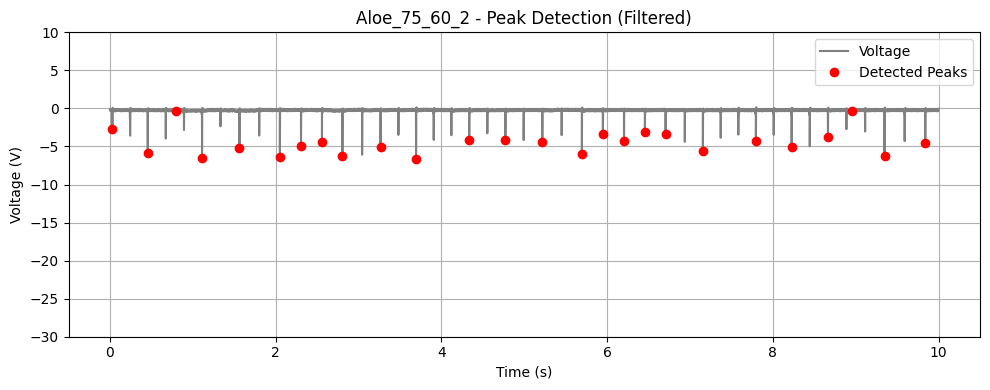

Aloe_75_60_4_Vpp: 7.91 V
Aloe_75_60_4_Peak number: 21개
Aloe_75_60_4_표준편차: 1.09
Aloe_75_60_4_주파수: 2.51 Hz


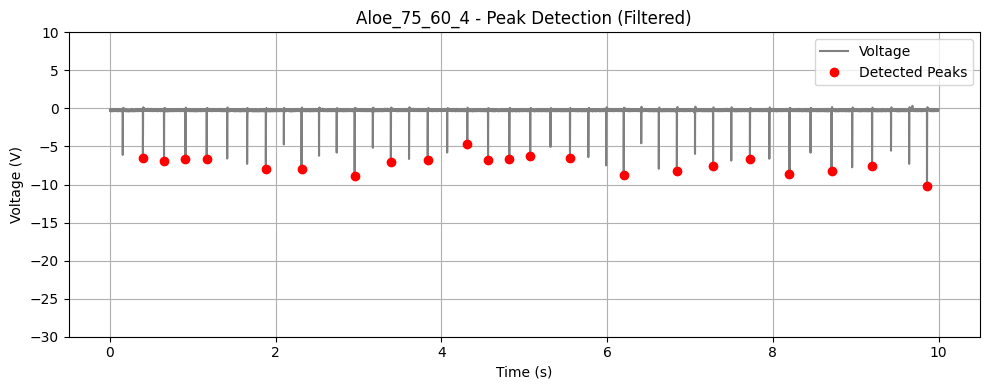

Aloe_75_60_6_Vpp: 11.48 V
Aloe_75_60_6_Peak number: 23개
Aloe_75_60_6_표준편차: 1.35
Aloe_75_60_6_주파수: 2.71 Hz


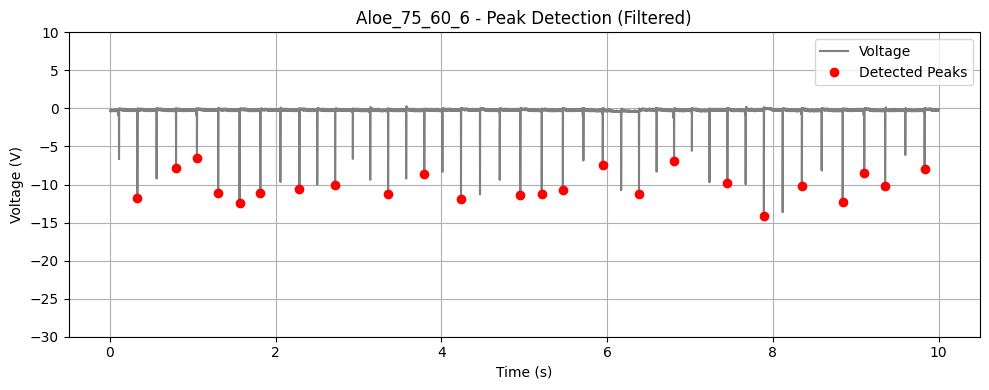

Aloe_75_60_8_Vpp: 18.29 V
Aloe_75_60_8_Peak number: 22개
Aloe_75_60_8_표준편차: 1.41
Aloe_75_60_8_주파수: 2.43 Hz


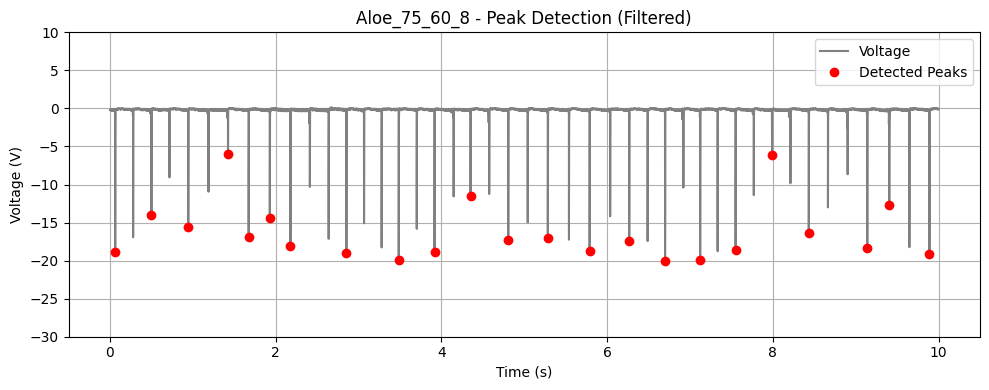

Flat_30_40_2_Vpp: 17.59 V
Flat_30_40_2_Peak number: 21개
Flat_30_40_2_표준편차: 2.32
Flat_30_40_2_주파수: 2.38 Hz


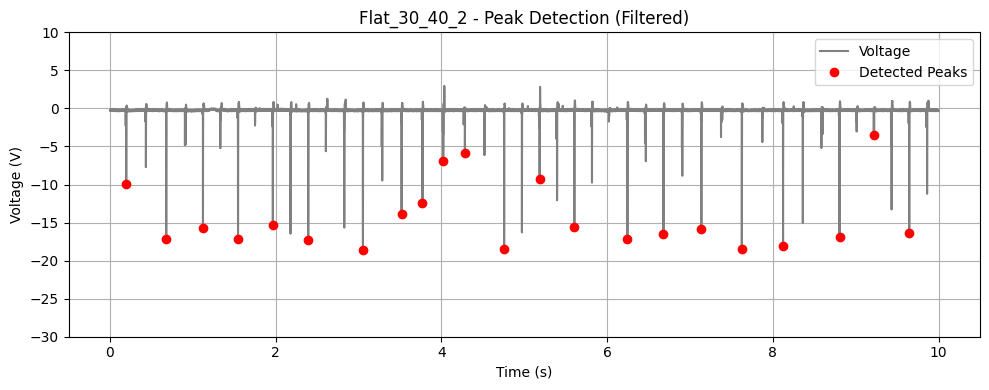

Flat_30_40_4_Vpp: 4.25 V
Flat_30_40_4_Peak number: 26개
Flat_30_40_4_표준편차: 2.08
Flat_30_40_4_주파수: 2.79 Hz


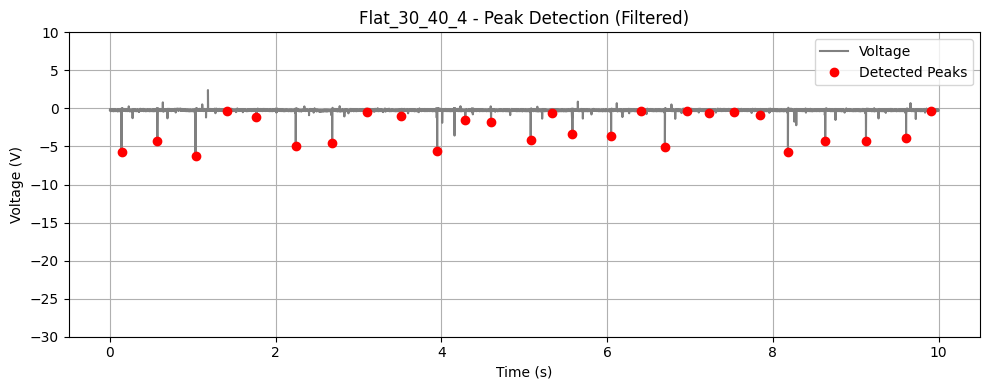

Flat_30_40_6_Vpp: 1.88 V
Flat_30_40_6_Peak number: 24개
Flat_30_40_6_표준편차: 0.30
Flat_30_40_6_주파수: 2.57 Hz


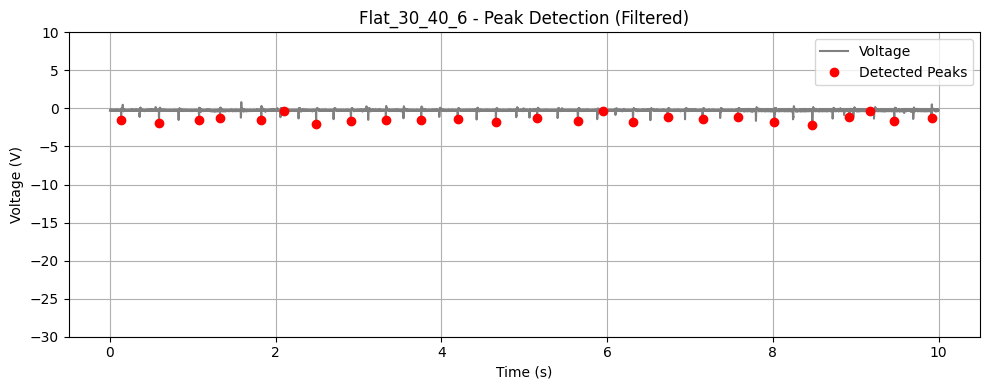

Flat_30_40_8_Vpp: 2.62 V
Flat_30_40_8_Peak number: 27개
Flat_30_40_8_표준편차: 0.75
Flat_30_40_8_주파수: 2.81 Hz


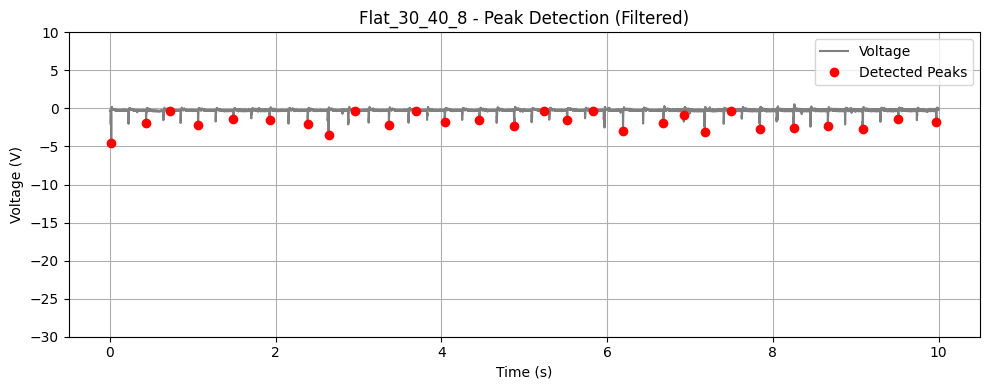

Flat_30_60_2_Vpp: 9.00 V
Flat_30_60_2_Peak number: 21개
Flat_30_60_2_표준편차: 1.04
Flat_30_60_2_주파수: 2.23 Hz


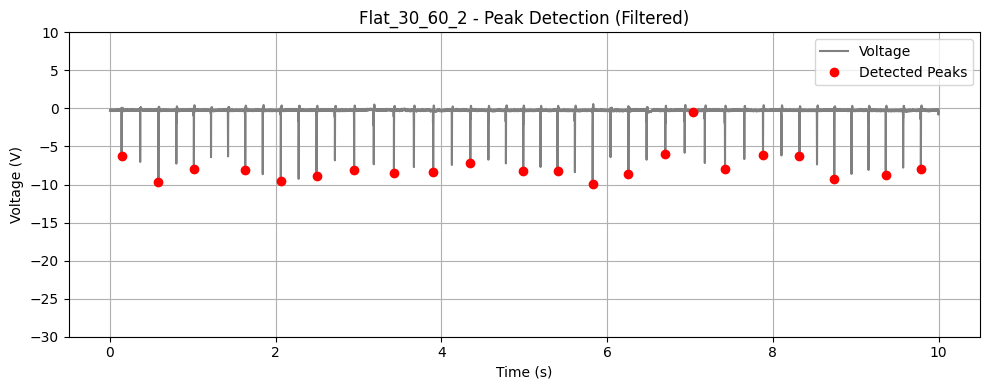

Flat_30_60_4_Vpp: 5.55 V
Flat_30_60_4_Peak number: 23개
Flat_30_60_4_표준편차: 0.77
Flat_30_60_4_주파수: 2.48 Hz


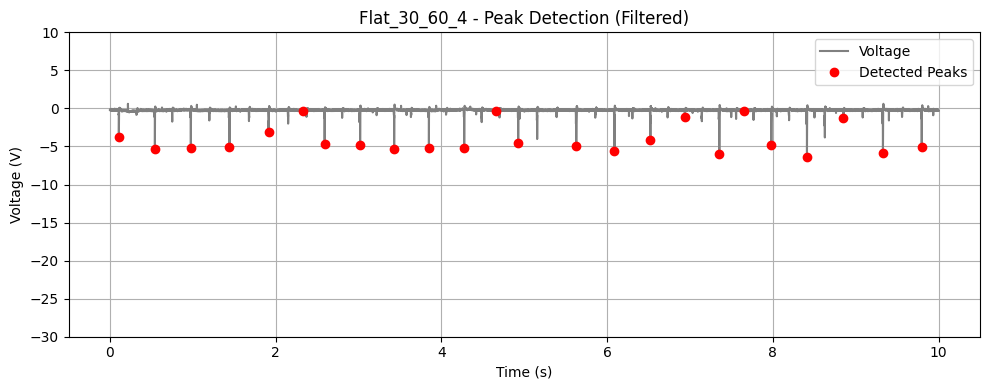

Flat_30_60_6_Vpp: 3.56 V
Flat_30_60_6_Peak number: 18개
Flat_30_60_6_표준편차: 3.41
Flat_30_60_6_주파수: 2.14 Hz


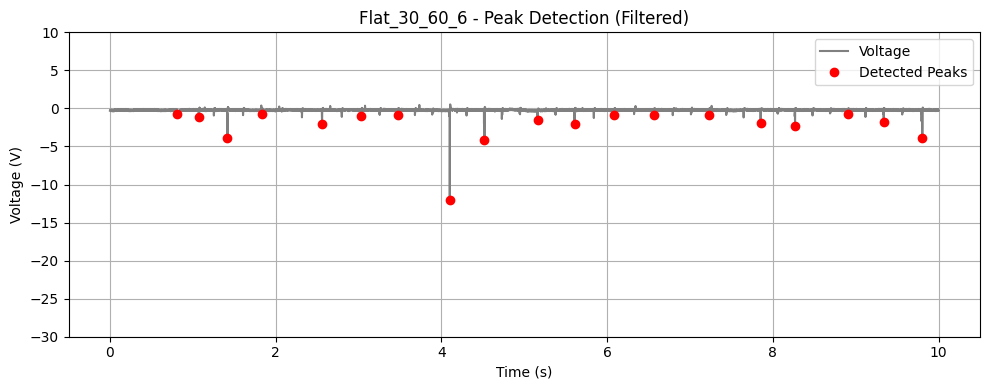

Flat_30_60_8_Vpp: 1.57 V
Flat_30_60_8_Peak number: 24개
Flat_30_60_8_표준편차: 0.93
Flat_30_60_8_주파수: 2.50 Hz


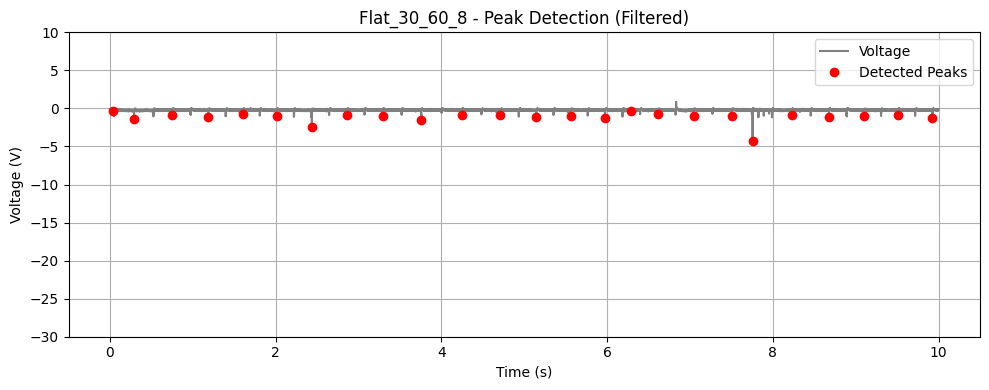

Flat_45_40_2_Vpp: 9.29 V
Flat_45_40_2_Peak number: 18개
Flat_45_40_2_표준편차: 0.62
Flat_45_40_2_주파수: 1.95 Hz


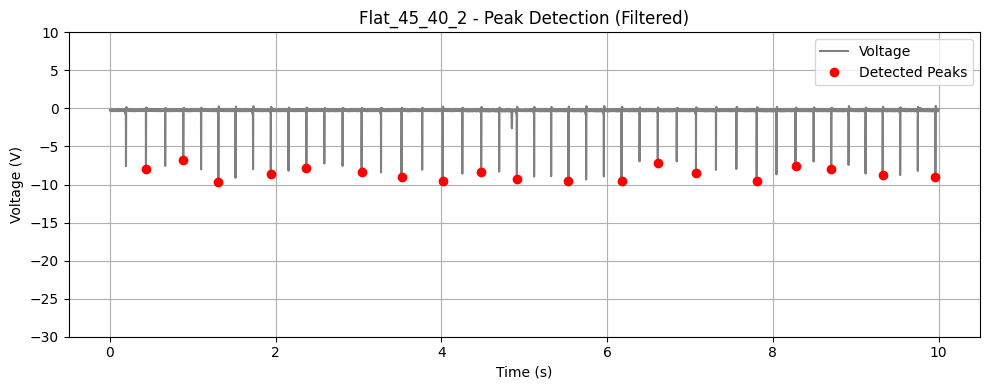

Flat_45_40_4_Vpp: 7.99 V
Flat_45_40_4_Peak number: 20개
Flat_45_40_4_표준편차: 7.71
Flat_45_40_4_주파수: 2.31 Hz


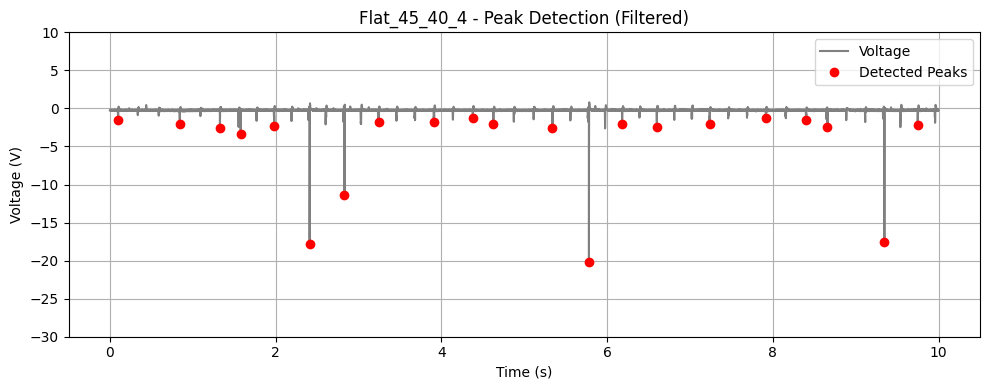

Flat_45_40_6_Vpp: 2.25 V
Flat_45_40_6_Peak number: 26개
Flat_45_40_6_표준편차: 1.24
Flat_45_40_6_주파수: 2.74 Hz


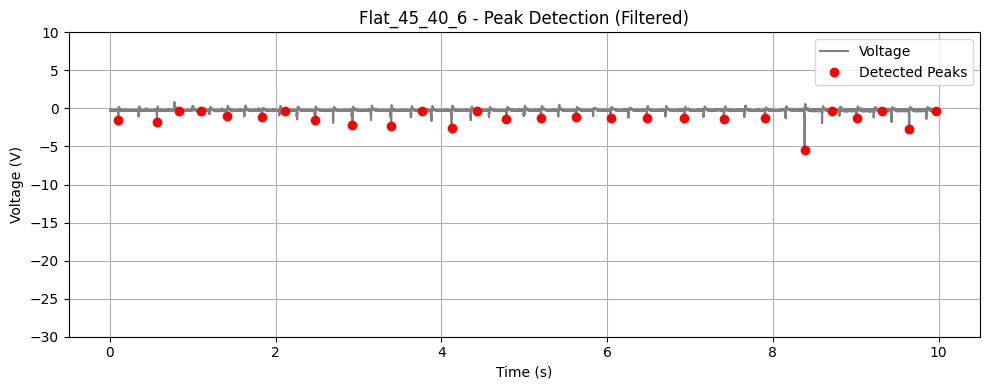

Flat_45_40_8_Vpp: 1.51 V
Flat_45_40_8_Peak number: 26개
Flat_45_40_8_표준편차: 0.77
Flat_45_40_8_주파수: 2.82 Hz


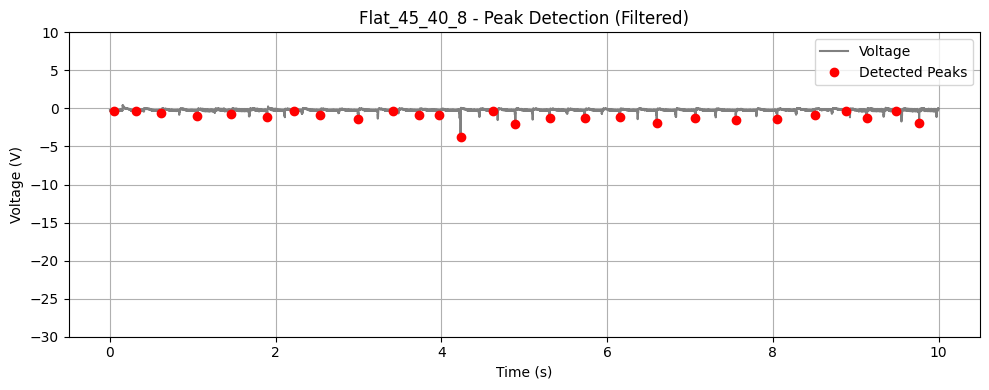

Flat_45_60_2_Vpp: 8.48 V
Flat_45_60_2_Peak number: 18개
Flat_45_60_2_표준편차: 0.67
Flat_45_60_2_주파수: 1.91 Hz


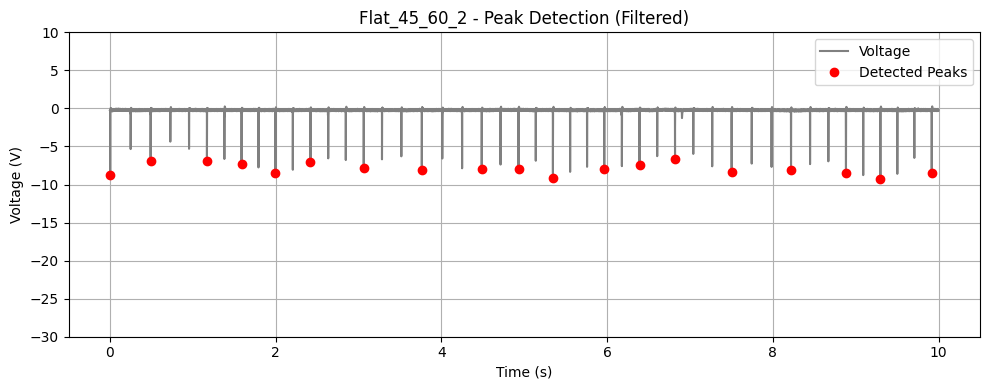

Flat_45_60_4_Vpp: 11.76 V
Flat_45_60_4_Peak number: 20개
Flat_45_60_4_표준편차: 1.08
Flat_45_60_4_주파수: 2.10 Hz


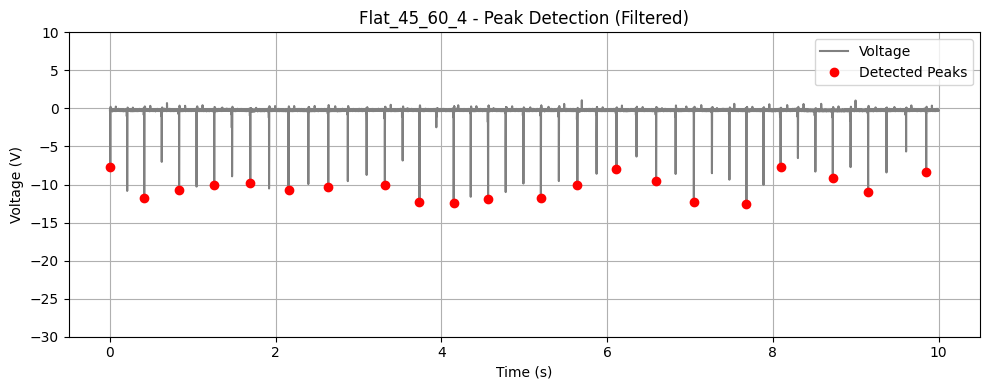

Flat_45_60_6_Vpp: 1.81 V
Flat_45_60_6_Peak number: 27개
Flat_45_60_6_표준편차: 0.50
Flat_45_60_6_주파수: 2.88 Hz


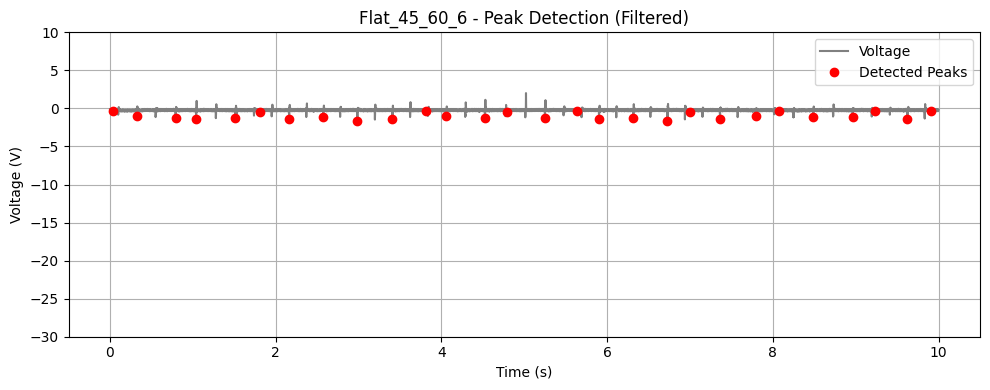

Flat_45_60_8_Vpp: 2.97 V
Flat_45_60_8_Peak number: 26개
Flat_45_60_8_표준편차: 0.69
Flat_45_60_8_주파수: 2.73 Hz


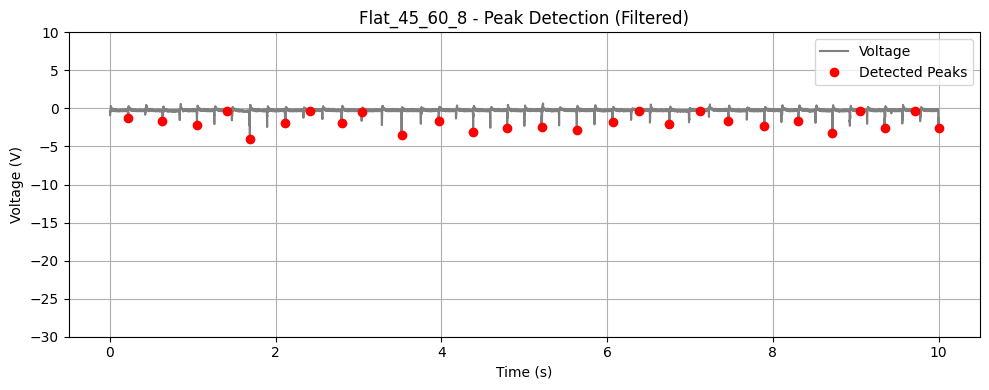

Flat_60_40_2_Vpp: 11.53 V
Flat_60_40_2_Peak number: 23개
Flat_60_40_2_표준편차: 12.74
Flat_60_40_2_주파수: 2.70 Hz


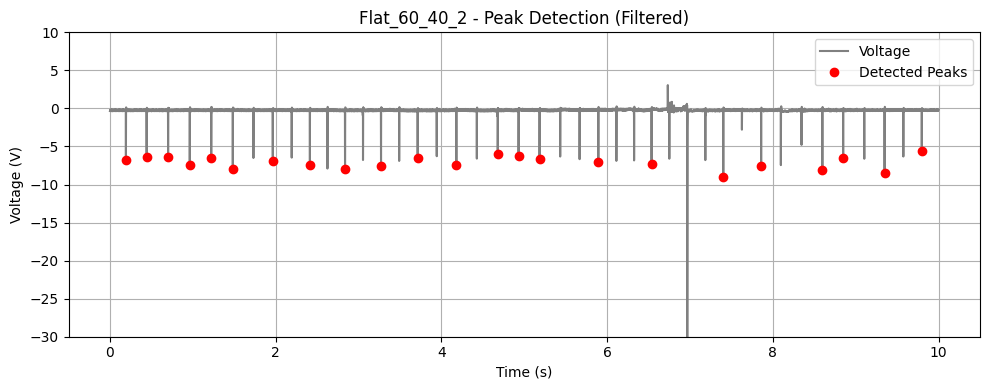

Flat_60_40_4_Vpp: 12.10 V
Flat_60_40_4_Peak number: 20개
Flat_60_40_4_표준편차: 0.57
Flat_60_40_4_주파수: 2.40 Hz


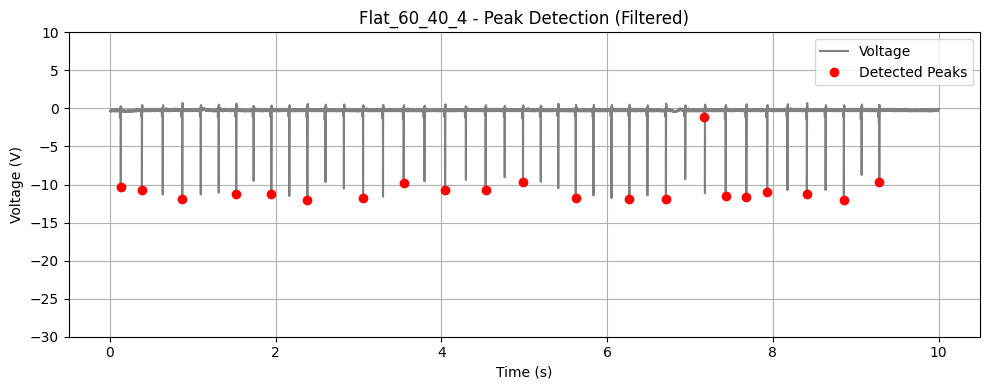

Flat_60_40_6_Vpp: 7.04 V
Flat_60_40_6_Peak number: 24개
Flat_60_40_6_표준편차: 3.12
Flat_60_40_6_주파수: 2.62 Hz


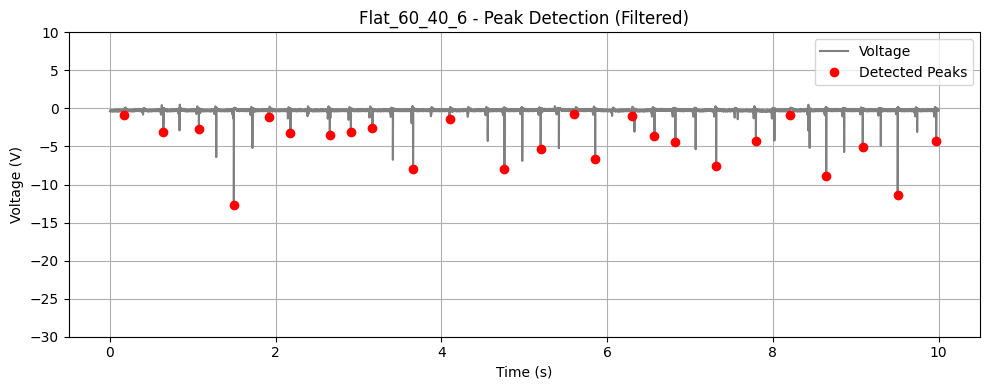

Flat_60_40_8_Vpp: 4.58 V
Flat_60_40_8_Peak number: 21개
Flat_60_40_8_표준편차: 4.00
Flat_60_40_8_주파수: 2.43 Hz


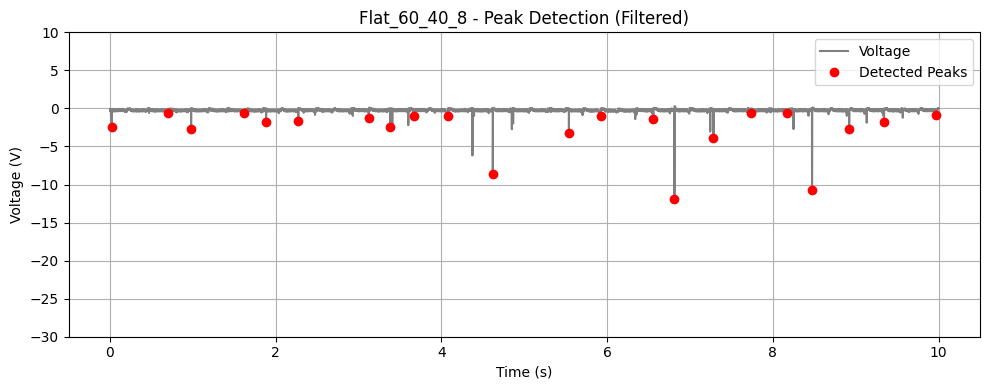

Flat_60_60_2_Vpp: 7.64 V
Flat_60_60_2_Peak number: 20개
Flat_60_60_2_표준편차: 0.60
Flat_60_60_2_주파수: 2.21 Hz


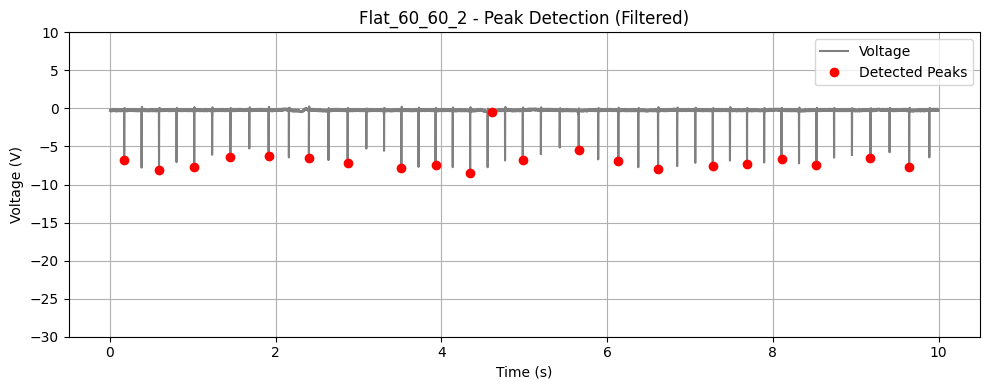

Flat_60_60_4_Vpp: 13.61 V
Flat_60_60_4_Peak number: 20개
Flat_60_60_4_표준편차: 1.09
Flat_60_60_4_주파수: 2.14 Hz


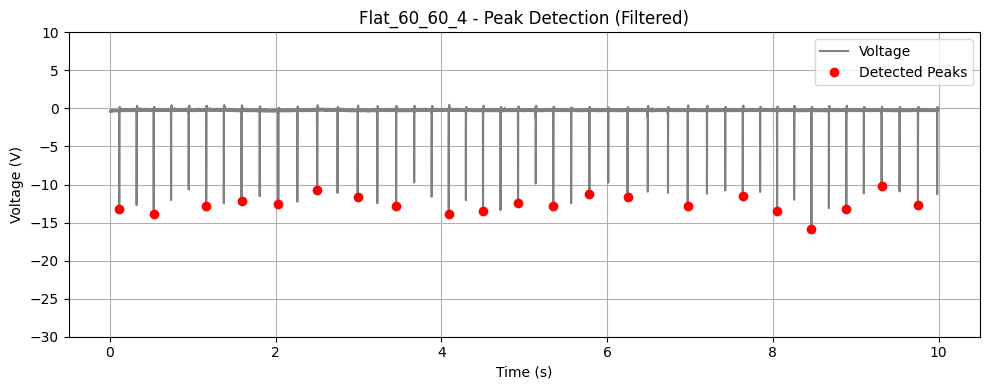

Flat_60_60_6_Vpp: 9.60 V
Flat_60_60_6_Peak number: 19개
Flat_60_60_6_표준편차: 0.95
Flat_60_60_6_주파수: 2.13 Hz


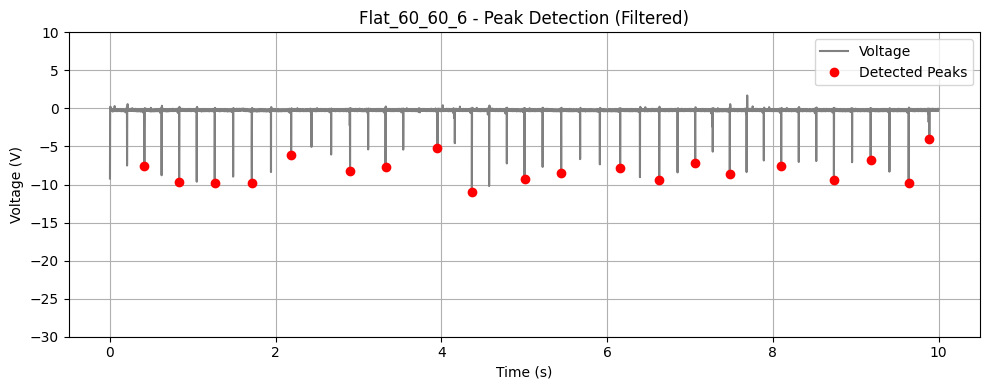

Flat_60_60_8_Vpp: 1.71 V
Flat_60_60_8_Peak number: 26개
Flat_60_60_8_표준편차: 0.54
Flat_60_60_8_주파수: 2.73 Hz


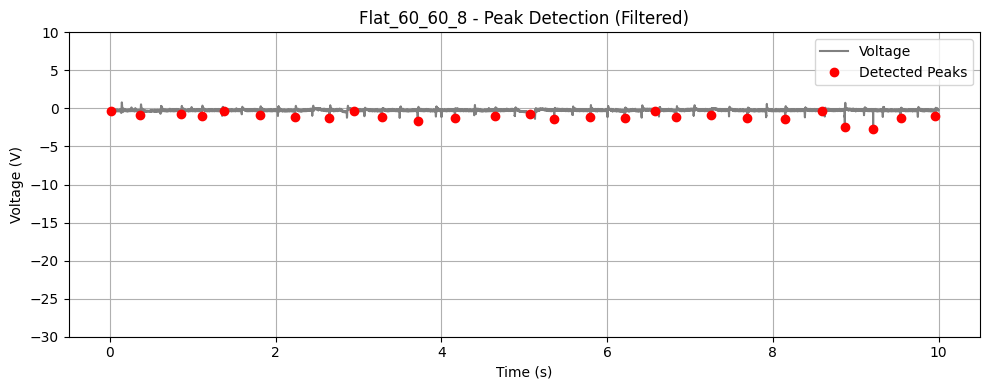

Flat_75_40_2_Vpp: 3.35 V
Flat_75_40_2_Peak number: 24개
Flat_75_40_2_표준편차: 0.67
Flat_75_40_2_주파수: 2.67 Hz


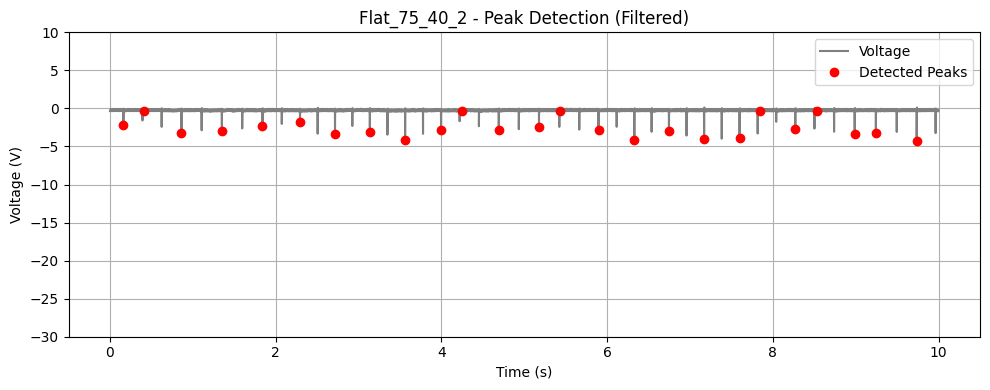

Flat_75_40_4_Vpp: 7.01 V
Flat_75_40_4_Peak number: 19개
Flat_75_40_4_표준편차: 0.58
Flat_75_40_4_주파수: 2.20 Hz


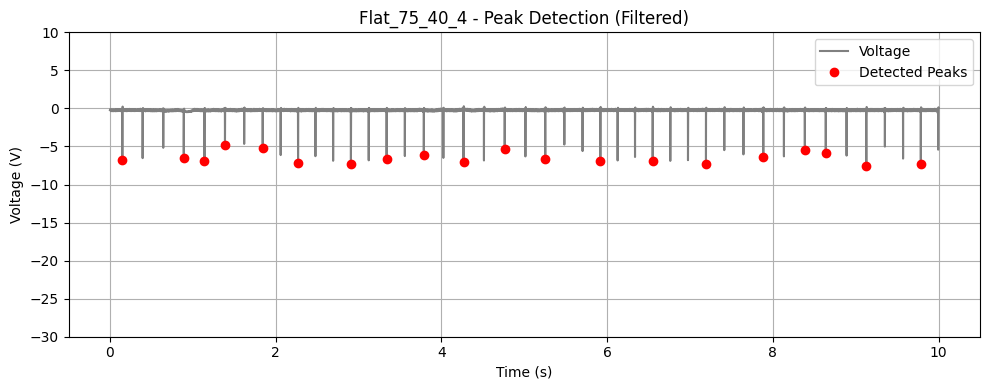

Flat_75_40_6_Vpp: 7.45 V
Flat_75_40_6_Peak number: 20개
Flat_75_40_6_표준편차: 0.62
Flat_75_40_6_주파수: 2.25 Hz


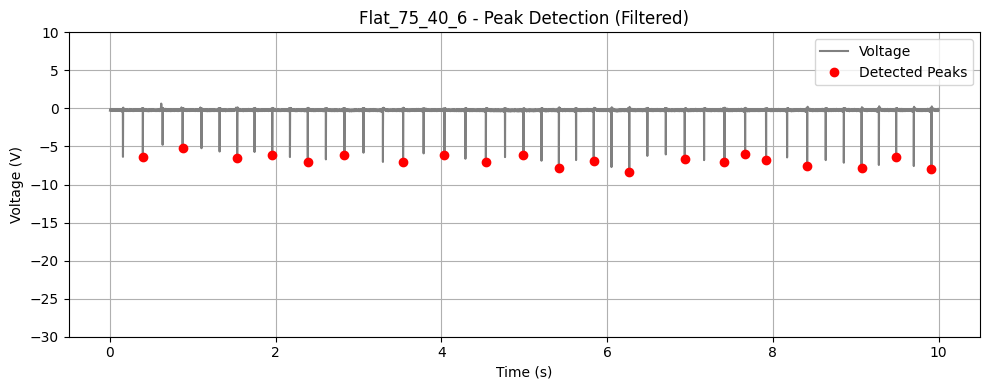

Flat_75_40_8_Vpp: 11.15 V
Flat_75_40_8_Peak number: 21개
Flat_75_40_8_표준편차: 0.71
Flat_75_40_8_주파수: 2.30 Hz


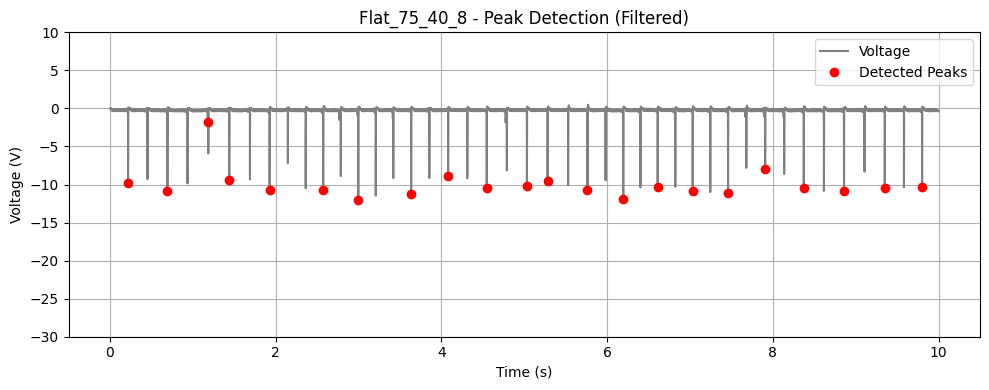

Flat_75_60_2_Vpp: 4.15 V
Flat_75_60_2_Peak number: 27개
Flat_75_60_2_표준편차: 0.51
Flat_75_60_2_주파수: 2.93 Hz


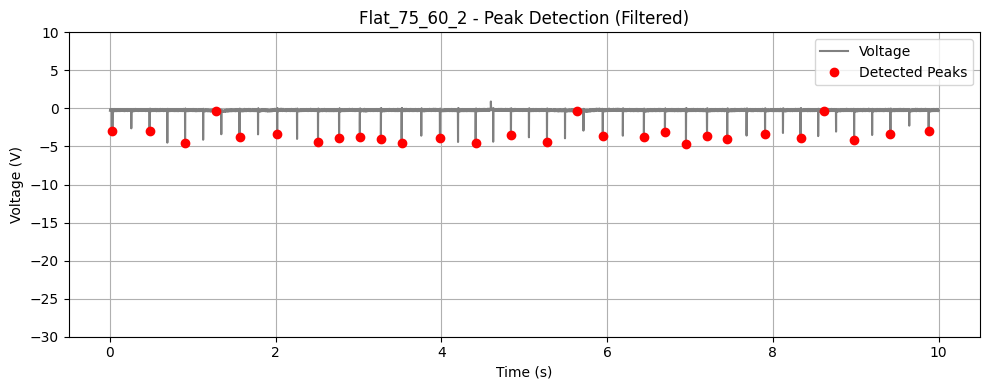

Flat_75_60_4_Vpp: 7.64 V
Flat_75_60_4_Peak number: 22개
Flat_75_60_4_표준편차: 0.52
Flat_75_60_4_주파수: 2.67 Hz


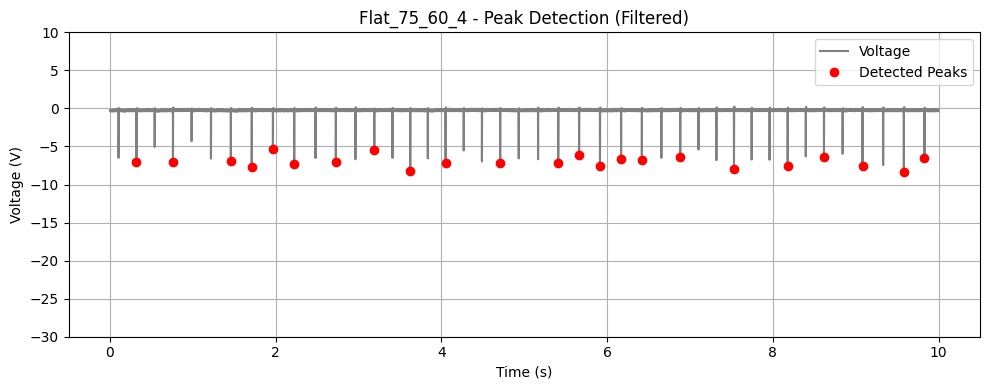

Flat_75_60_6_Vpp: 7.63 V
Flat_75_60_6_Peak number: 23개
Flat_75_60_6_표준편차: 0.50
Flat_75_60_6_주파수: 2.67 Hz


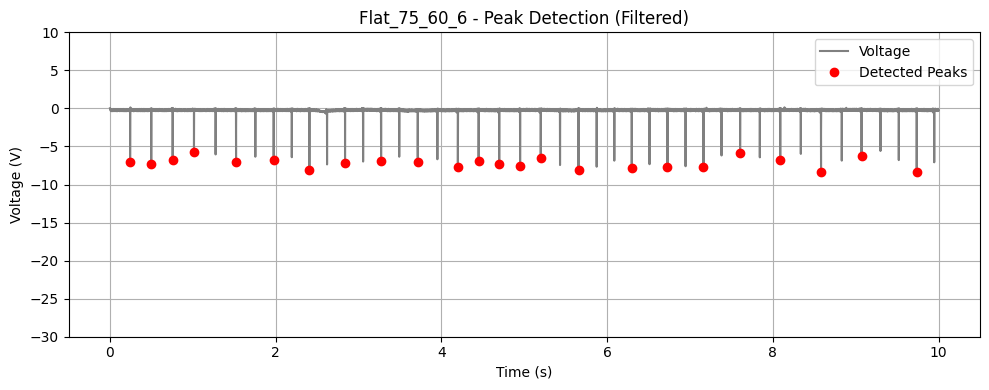

Flat_75_60_8_Vpp: 8.61 V
Flat_75_60_8_Peak number: 21개
Flat_75_60_8_표준편차: 0.87
Flat_75_60_8_주파수: 2.42 Hz


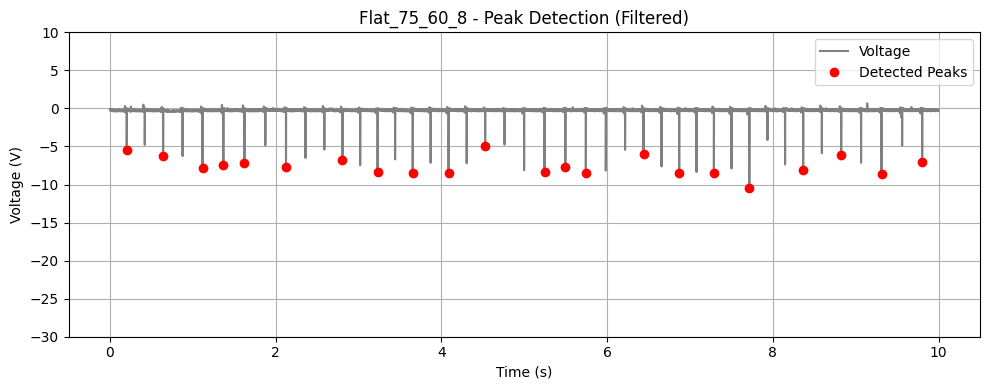


📊 모든 파일의 평균 Vpp, 표준편차, 평균 주파수 목록
Aloe_30_40_2.csv_Vpp: 5.09 V | 표준편차: 0.79 V | 주파수: 2.48 Hz
Aloe_30_40_4.csv_Vpp: 6.26 V | 표준편차: 3.75 V | 주파수: 2.44 Hz
Aloe_30_40_6.csv_Vpp: 7.91 V | 표준편차: 2.78 V | 주파수: 2.39 Hz
Aloe_30_40_8.csv_Vpp: 9.41 V | 표준편차: 4.85 V | 주파수: 2.32 Hz
Aloe_30_60_2.csv_Vpp: 5.89 V | 표준편차: 1.20 V | 주파수: 2.09 Hz
Aloe_30_60_4.csv_Vpp: 7.39 V | 표준편차: 1.52 V | 주파수: 2.16 Hz
Aloe_30_60_6.csv_Vpp: 10.39 V | 표준편차: 3.15 V | 주파수: 2.18 Hz
Aloe_30_60_8.csv_Vpp: 6.29 V | 표준편차: 4.36 V | 주파수: 2.19 Hz
Aloe_45_40_2.csv_Vpp: 7.02 V | 표준편차: 1.13 V | 주파수: 2.24 Hz
Aloe_45_40_4.csv_Vpp: 11.47 V | 표준편차: 3.02 V | 주파수: 2.22 Hz
Aloe_45_40_6.csv_Vpp: 13.36 V | 표준편차: 3.02 V | 주파수: 2.10 Hz
Aloe_45_40_8.csv_Vpp: 15.33 V | 표준편차: 5.86 V | 주파수: 2.47 Hz
Aloe_45_60_2.csv_Vpp: 6.99 V | 표준편차: 0.62 V | 주파수: 2.14 Hz
Aloe_45_60_4.csv_Vpp: 11.93 V | 표준편차: 1.58 V | 주파수: 2.18 Hz
Aloe_45_60_6.csv_Vpp: 10.63 V | 표준편차: 1.96 V | 주파수: 2.00 Hz
Aloe_45_60_8.csv_Vpp: 11.51 V | 표준편차: 3.68 V | 주파수: 2.20 Hz
Aloe_60_40_2.cs

In [36]:
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
all_vpp_values = []
file_std_values = []
all_freq_values = []  ### 추가: 주파수 리스트 저장

# -------------------------------
# 파일별 처리
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    try:
        # 데이터 로드
        df = pd.read_csv(file_path)
        time = df.iloc[:, 0].values
        voltage = df.iloc[:, 1].values

        # 샘플링 속도
        total_time = time[-1] - time[0]
        sampling_rate = len(time) / total_time
        distance = int(sampling_rate * min_distance_sec)

        # 피크 검출 (음의 피크 대상으로)
        prom = max(np.std(voltage) * prominence_ratio, min_prominence)
        raw_peaks, properties = find_peaks(-voltage, prominence=prom, distance=distance)

        # 피크 필터링
        max_amplitude = np.max(-voltage)
        final_peaks = []
        for i in raw_peaks:
            left = max(0, i - int(0.05 * sampling_rate))
            right = min(len(voltage), i + int(0.05 * sampling_rate))
            local_noise = max(np.std(voltage[left:right]), 1e-6)
            signal = -voltage[i]
            if signal > max_amplitude * min_relative_height and signal / local_noise > snr_threshold:
                final_peaks.append(i)

        final_peaks = np.array(final_peaks, dtype=int)
        peak_times = time[final_peaks]

        # Vpp 계산
        vpp_list = []
        for i in range(len(final_peaks) - 1):
            start = final_peaks[i]
            end = final_peaks[i + 1]
            vpp = np.max(voltage[start:end + 1]) - np.min(voltage[start:end + 1])
            vpp_list.append(vpp)

        mean_vpp = np.mean(vpp_list) if vpp_list else 0
        std = np.std(vpp_list, ddof=1) if vpp_list else 0

        # 주파수 계산
        if len(peak_times) < 2:
            mean_freq = 0
        else:
            periods = np.diff(peak_times)
            mean_freq = np.mean(1 / periods)

        # 결과 출력
        base_name = os.path.splitext(file_name)[0]
        print(f"{base_name}_Vpp: {mean_vpp:.2f} V")
        print(f"{base_name}_Peak number: {len(vpp_list):.0f}개")
        print(f"{base_name}_표준편차: {std:.2f}")
        print(f"{base_name}_주파수: {mean_freq:.2f} Hz")

        # 결과 저장
        all_vpp_values.append(mean_vpp)
        file_std_values.append(std)
        all_freq_values.append(mean_freq)  ### 추가: 각 파일 평균 주파수 저장

        # -------------------------------
        # 그래프 출력
        plt.figure(figsize=(10, 4))
        plt.plot(time, voltage, color='gray', label='Voltage')
        if len(final_peaks) > 0:
            plt.plot(time[final_peaks], voltage[final_peaks], 'ro', label='Detected Peaks')
        plt.title(f"{base_name} - Peak Detection (Filtered)")
        plt.xlabel("Time (s)")
        plt.ylabel("Voltage (V)")
        plt.ylim(-30,10)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"{file_name} 처리 중 오류 발생: {e}")

# -------------------------------
# 전체 요약 출력
print("\n==============================")
print("📊 모든 파일의 평균 Vpp, 표준편차, 평균 주파수 목록")
for i in range(len(all_vpp_values)):
    print(f"{csv_files[i]}_Vpp: {all_vpp_values[i]:.2f} V | 표준편차: {file_std_values[i]:.2f} V | 주파수: {all_freq_values[i]:.2f} Hz")

if all_vpp_values:
    overall_mean_vpp = np.mean(all_vpp_values)
    overall_std_vpp = np.std(all_vpp_values, ddof=1)
    overall_mean_freq = np.mean(all_freq_values) if all_freq_values else 0
    overall_std_freq = np.std(all_freq_values, ddof=1) if all_freq_values else 0

    print("\n==============================")
    print(f"📈 전체 평균 Vpp: {overall_mean_vpp:.2f} V")
    print(f"📉 표준편차 (Vpp): {overall_std_vpp:.2f} V")
    print(f"🎵 전체 평균 주파수: {overall_mean_freq:.2f} Hz")
    print(f"🎯 표준편차 (주파수): {overall_std_freq:.2f} Hz")
else:
    print("📭 Vpp 데이터를 계산할 수 없습니다.")